In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l
import matplotlib.pyplot as plt

In [2]:
cache_dir = os.path.join('..', 'data')
train_data = pd.read_csv(os.path.join(cache_dir, 'train.csv'))
test_data = pd.read_csv(os.path.join(cache_dir, 'test.csv'))

In [3]:
test_data.head()

,Id,Address,Summary,Type,Year built,Heating,Cooling,Parking,Lot,Bedrooms,...,Parking features,Tax assessed value,Annual tax amount,Listed On,Listed Price,Last Sold On,Last Sold Price,City,Zip,State
0,47439,3034 N Coolidge Ave,Live within steps to the scenic views on the L...,SingleFamily,2020.0,Central,Central Air,Tandem Uncovered,940.0,2,...,Tandem Uncovered,NaN,NaN,2020-11-06,799900.0,2020-07-01,819000.0,Dodgertown,90090,CA
1,47440,565 Kenilworth Ave,duplex fixer. Input for comps only,SingleFamily,1924.0,Natural Gas,None,Detached,10018.8,3,...,Detached,521977.0,7494.0,2014-04-04,479950.0,2020-11-03,15000.0,San Leandro,94577,CA
2,47441,3028 N Coolidge Ave,Live within steps to the scenic views on the L...,SingleFamily,2020.0,Central,Central Air,Tandem Uncovered,940.0,2,...,Tandem Uncovered,NaN,NaN,2020-11-12,839900.0,NaN,NaN,Los Angeles,90039,CA
3,47442,3022 N North Coolidge Ave,Live within steps to the scenic views on the L...,SingleFamily,2020.0,Central,Central Air,Tandem Uncovered,940.0,2,...,Tandem Uncovered,442800.0,5370.0,2020-11-06,809900.0,2020-09-21,810000.0,Dodgertown,90090,CA
4,47443,2515 Admiral Cir,"This beautiful, spacious home built in 2017 is...",SingleFamily,2017.0,Forced Air,Central Air,"Garage Door Opener, Attached",2613.6,4,...,"Garage Door Opener, Attached",965282.0,12912.0,2020-12-02,1095000.0,2019-12-27,1041000.0,Hayward,94545,CA


In [4]:
train_nan = pd.DataFrame(train_data.isnull().sum(), columns=['nan_sum'])
train_nan['percentage %'] = train_nan['nan_sum'] / train_data.shape[0] * 100
train_nan

,nan_sum,percentage %
Id,0,0.000000
Address,0,0.000000
Sold Price,0,0.000000
Summary,350,0.737790
Type,0,0.000000
Year built,1045,2.202829
Heating,6465,13.628028
Cooling,10622,22.390860
Parking,908,1.914037
Lot,14181,29.893126


In [5]:
train_data['Sold Price'].fillna(train_data['Listed Price'], inplace=True)
train_data['Listed Price'].fillna(train_data['Sold Price'], inplace=True)

In [6]:
all_features = pd.concat((train_data.iloc[:, train_data.columns != 'Sold Price'],
                         test_data))

In [7]:
all_features['City Id'] = pd.factorize(all_features['City'])[0]

In [8]:
all_features['Score_sum'] = all_features['Elementary School Score'] + all_features['Middle School Score'] + all_features['High School Score']

In [9]:
drop_features = (['Id', 'Zip', 
                  'Elementary School Score', 'Middle School Score', 
                  'High School Score', 'City'])
all_features.drop(drop_features, 1, inplace=True)

/home/liwei/anaconda3/envs/yolo/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.


In [10]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x-x.mean()) / (x.std()))
all_features[numeric_features] = all_features[numeric_features].fillna(0)
all_features = all_features[numeric_features]
all_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79065 entries, 0 to 31625
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Year built                   79065 non-null  float64
 1   Lot                          79065 non-null  float64
 2   Bathrooms                    79065 non-null  float64
 3   Full bathrooms               79065 non-null  float64
 4   Total interior livable area  79065 non-null  float64
 5   Total spaces                 79065 non-null  float64
 6   Garage spaces                79065 non-null  float64
 7   Elementary School Distance   79065 non-null  float64
 8   Middle School Distance       79065 non-null  float64
 9   High School Distance         79065 non-null  float64
 10  Tax assessed value           79065 non-null  float64
 11  Annual tax amount            79065 non-null  float64
 12  Listed Price                 79065 non-null  float64
 13  Last Sold Price 

In [11]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, 
                              dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, 
                             dtype=torch.float32)
train_labels = torch.tensor(train_data['Sold Price'].values.reshape(-1, 1), 
                            dtype=torch.float32)

In [12]:
in_features = train_features.shape[1]

In [13]:
def get_net():
    net = nn.Sequential(nn.Linear(in_features, 32), 
                        nn.ReLU(),
                        nn.Dropout(0.1),
                        nn.Linear(32, 16),
                        nn.ReLU(),
                        nn.Dropout(0.1),
                        nn.Linear(16, 8),
                        nn.ReLU(),
                        nn.Dropout(0.1),
                        nn.Linear(8, 1),
                        )
    net.apply(init_weights)
    return net



def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
   

In [14]:
loss = nn.CrossEntropyLoss()
num_epochs, lr = 100, 0.001
batch_size = 128
net = get_net()
trainer = torch.optim.SGD(net.parameters(), lr=lr)

In [16]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k 
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j*fold_size, (j+1)*fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if i == j:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [26]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, trainer,
           batch_size):
    for i in range(k):
        X_train, y_train, X_valid, y_valid = get_k_fold_data(k, i, X_train, y_train)
        train_iter = d2l.load_array((X_train, y_train), batch_size)
        test_iter = d2l.load_array((X_valid, y_valid), batch_size)
        net = get_net()
        d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

AssertionError: 0.0

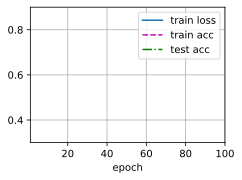

In [27]:
k, num_epochs, lr, batch_size = 5, 100, 0.01, 128
k_fold(k, train_features, train_labels, num_epochs, lr,
                          trainer, batch_size)

In [ ]:
submission = train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)

In [ ]:
print(submission.head())